In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/polymorphous-light-eruption-33.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/milia-11.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/pseudo-porphyria-2.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/sun-damaged-skin-12.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/phototoxic-reactions-72.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/melasma-34.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/vitiligo-4.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/milia-3.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/porphyrias-51.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/erythema-ab-igne-16.jpg
/kaggle/input/dermnet/test/Light Diseases and Disorders of Pigmentation/m

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Initialize dictionaries to store loss and accuracy
train_losses = {'CNN':[],'AlexNet':[],'ResNet':[],'InceptionNet':[]}
valid_losses = {'CNN':[],'AlexNet':[],'ResNet':[],'InceptionNet':[]}
train_accuracies = {'CNN':[],'AlexNet':[],'ResNet':[],'InceptionNet':[]}
valid_accuracies = {'CNN':[],'AlexNet':[],'ResNet':[],'InceptionNet':[]}


In [5]:
def trainModel(model, model_name, trainLoader, valLoader, criterion, optimizer, device,num_epochs):
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            # Extract tensor from model output if necessary
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Adjust based on model output structure
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainLoader)
        train_accuracy = (correct / total) * 100
        
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in valLoader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                # Extract tensor from model output if necessary
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Adjust based on model output structure
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        valid_loss = running_val_loss / len(valLoader)
        valid_accuracy = (val_correct / val_total) * 100
        
        # Store the results in the corresponding lists
        train_losses[model_name].append(train_loss)
        valid_losses[model_name].append(valid_loss)
        train_accuracies[model_name].append(train_accuracy)
        valid_accuracies[model_name].append(valid_accuracy)
        
        # Print the results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

In [6]:
# Plotting loss and accuracy curves
def plotCurve(modelName, train_losses,valid_losses,train_accuracies,valid_accuracies):
    
    plt.figure(figsize=(12, 5))
    plt.title(modelName)

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
class CNNetwork(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNNetwork, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 23)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
transform = transforms.Compose([transforms.Resize((32,32)), 
                                transforms.ToTensor()
                               ])

# Define paths to the dataset directories
train_dir = '/kaggle/input/dermnet/train'  # Update these paths as needed
test_dir = '/kaggle/input/dermnet/test'
trainDataset = datasets.ImageFolder(root=train_dir, transform=transform)
trainLoader = DataLoader(dataset= trainDataset , batch_size= 100, shuffle=True)
valDataset = datasets.ImageFolder(root=test_dir, transform=transform)
valLoader = DataLoader(dataset= valDataset , batch_size= 100, shuffle=True)

Epoch 1/10
Train Loss: 2.9541, Train Accuracy: 11.40%
Valid Loss: 2.9044, Valid Accuracy: 12.69%
Epoch 2/10
Train Loss: 2.8749, Train Accuracy: 14.33%
Valid Loss: 2.8631, Valid Accuracy: 13.34%
Epoch 3/10
Train Loss: 2.8275, Train Accuracy: 15.63%
Valid Loss: 2.8402, Valid Accuracy: 13.27%
Epoch 4/10
Train Loss: 2.7922, Train Accuracy: 16.93%
Valid Loss: 2.8149, Valid Accuracy: 15.07%
Epoch 5/10
Train Loss: 2.7607, Train Accuracy: 18.24%
Valid Loss: 2.7923, Valid Accuracy: 17.34%
Epoch 6/10
Train Loss: 2.7325, Train Accuracy: 19.08%
Valid Loss: 2.7586, Valid Accuracy: 17.54%
Epoch 7/10
Train Loss: 2.7094, Train Accuracy: 19.88%
Valid Loss: 2.7718, Valid Accuracy: 18.89%
Epoch 8/10
Train Loss: 2.6842, Train Accuracy: 21.10%
Valid Loss: 2.7340, Valid Accuracy: 19.72%
Epoch 9/10
Train Loss: 2.6597, Train Accuracy: 21.50%
Valid Loss: 2.6850, Valid Accuracy: 21.29%
Epoch 10/10
Train Loss: 2.6363, Train Accuracy: 22.07%
Valid Loss: 2.6775, Valid Accuracy: 20.91%


/tmp/ipykernel_25/4036692992.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


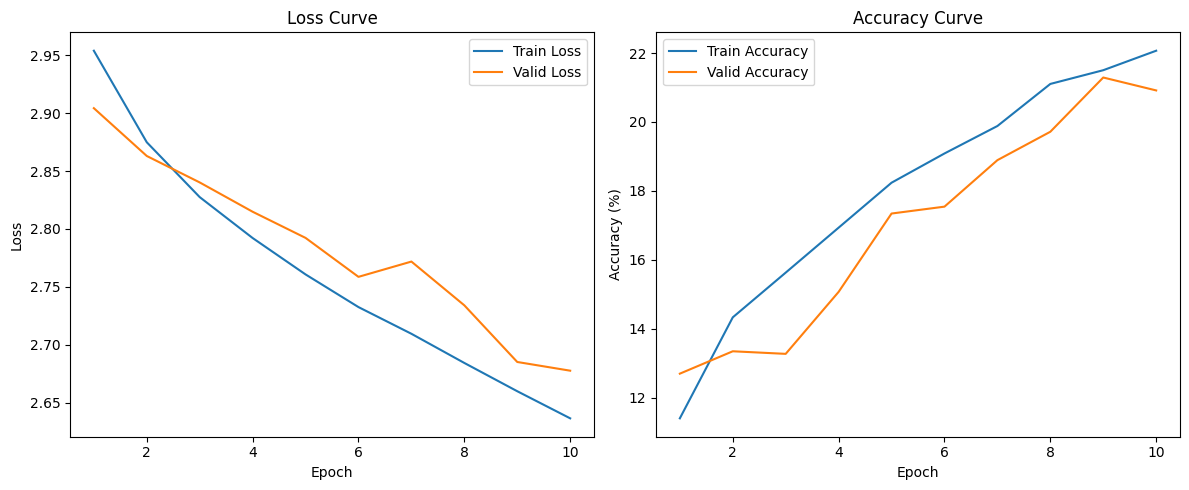

In [9]:
modelCNN = CNNetwork()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizerCNN = torch.optim.SGD(modelCNN.parameters(), lr = learning_rate, momentum = 0.8)

num_epochs = 10  # Set the number of epochs
trainModel(modelCNN,'CNN', trainLoader,valLoader, criterion, optimizerCNN, device,num_epochs)
plotCurve('CNN', train_losses['CNN'],valid_losses['CNN'],
          train_accuracies['CNN'],valid_accuracies['CNN'])

In [10]:
num_classes = 23

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 134MB/s]


Epoch 1/10
Train Loss: 2.4515, Train Accuracy: 27.25%
Valid Loss: 2.3012, Valid Accuracy: 33.08%
Epoch 2/10
Train Loss: 2.0931, Train Accuracy: 37.11%
Valid Loss: 2.0882, Valid Accuracy: 39.18%
Epoch 3/10
Train Loss: 1.8615, Train Accuracy: 43.39%
Valid Loss: 2.0261, Valid Accuracy: 39.86%
Epoch 4/10
Train Loss: 1.6441, Train Accuracy: 50.00%
Valid Loss: 1.9406, Valid Accuracy: 43.83%
Epoch 5/10
Train Loss: 1.4566, Train Accuracy: 55.04%
Valid Loss: 1.9291, Valid Accuracy: 44.88%
Epoch 6/10
Train Loss: 1.2880, Train Accuracy: 59.79%
Valid Loss: 1.8741, Valid Accuracy: 45.90%
Epoch 7/10
Train Loss: 1.1238, Train Accuracy: 64.64%
Valid Loss: 1.8666, Valid Accuracy: 47.55%
Epoch 8/10
Train Loss: 0.9734, Train Accuracy: 69.29%
Valid Loss: 1.8589, Valid Accuracy: 49.33%
Epoch 9/10
Train Loss: 0.8352, Train Accuracy: 73.22%
Valid Loss: 1.7892, Valid Accuracy: 51.72%
Epoch 10/10
Train Loss: 0.7179, Train Accuracy: 76.97%
Valid Loss: 1.9619, Valid Accuracy: 51.72%


/tmp/ipykernel_25/4036692992.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


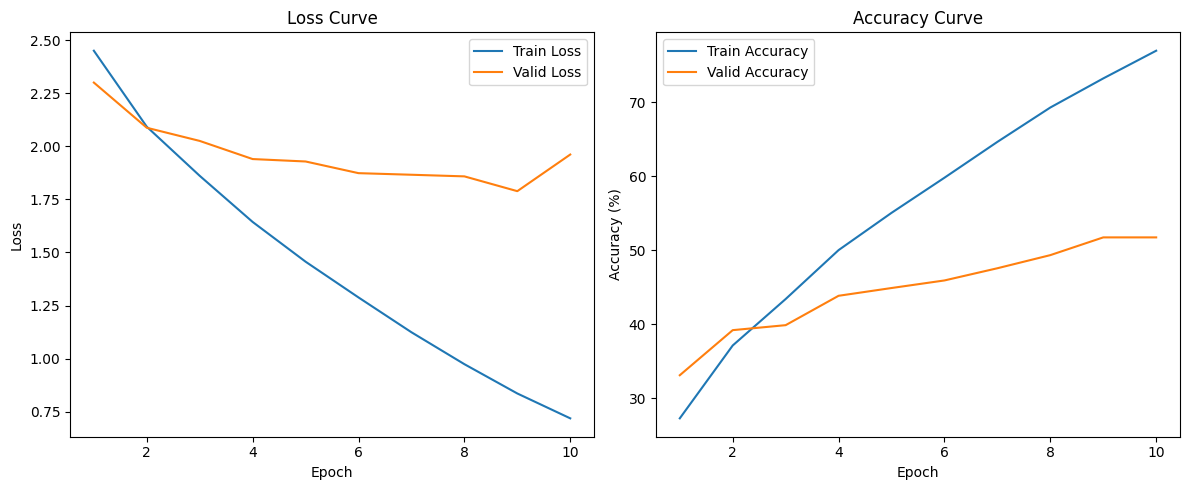

In [11]:
# preprocessAlexNet = transforms.Compose([transforms.Resize(254),
#                                         transforms.ToTensor(),
#                                        ])

preprocessAlexNet = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224, which is the standard input size for AlexNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

trainDataAlexNet = datasets.ImageFolder(root=train_dir, transform=preprocessAlexNet)
trainLoaderAlexNet = DataLoader(dataset= trainDataAlexNet , batch_size= 100, shuffle=True)
valDataDataAlexNet = datasets.ImageFolder(root=test_dir, transform=preprocessAlexNet)
valLoaderAlexNet = DataLoader(dataset= valDataDataAlexNet , batch_size= 100, shuffle=True)

modelAlexNet = models.alexnet(pretrained=True)
modelAlexNet.classifier[6] = nn.Linear(4096, num_classes)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizerAlexNet = torch.optim.SGD(modelAlexNet.parameters(), lr = learning_rate, momentum = 0.8)

num_epochs = 10  # Set the number of epochs
trainModel(modelAlexNet,'AlexNet', trainLoaderAlexNet,valLoaderAlexNet, criterion, optimizerAlexNet, device,num_epochs)
plotCurve('AlexNet', train_losses['AlexNet'],valid_losses['AlexNet'],
          train_accuracies['AlexNet'],valid_accuracies['AlexNet'])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


Epoch 1/10
Train Loss: 2.2384, Train Accuracy: 33.75%
Valid Loss: 1.9240, Valid Accuracy: 42.45%
Epoch 2/10
Train Loss: 1.5163, Train Accuracy: 54.47%
Valid Loss: 1.8173, Valid Accuracy: 47.68%
Epoch 3/10
Train Loss: 0.9872, Train Accuracy: 69.91%
Valid Loss: 1.9092, Valid Accuracy: 49.93%
Epoch 4/10
Train Loss: 0.5707, Train Accuracy: 83.00%
Valid Loss: 1.7897, Valid Accuracy: 52.37%
Epoch 5/10
Train Loss: 0.3103, Train Accuracy: 91.03%
Valid Loss: 1.7547, Valid Accuracy: 56.60%
Epoch 6/10
Train Loss: 0.1755, Train Accuracy: 95.02%
Valid Loss: 1.6532, Valid Accuracy: 57.50%
Epoch 7/10
Train Loss: 0.1176, Train Accuracy: 96.30%
Valid Loss: 1.7148, Valid Accuracy: 60.69%
Epoch 8/10
Train Loss: 0.0806, Train Accuracy: 96.91%
Valid Loss: 1.6749, Valid Accuracy: 61.44%
Epoch 9/10
Train Loss: 0.0611, Train Accuracy: 97.13%
Valid Loss: 1.6591, Valid Accuracy: 61.97%
Epoch 10/10
Train Loss: 0.0520, Train Accuracy: 97.39%
Valid Loss: 1.6152, Valid Accuracy: 62.94%


/tmp/ipykernel_25/4036692992.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


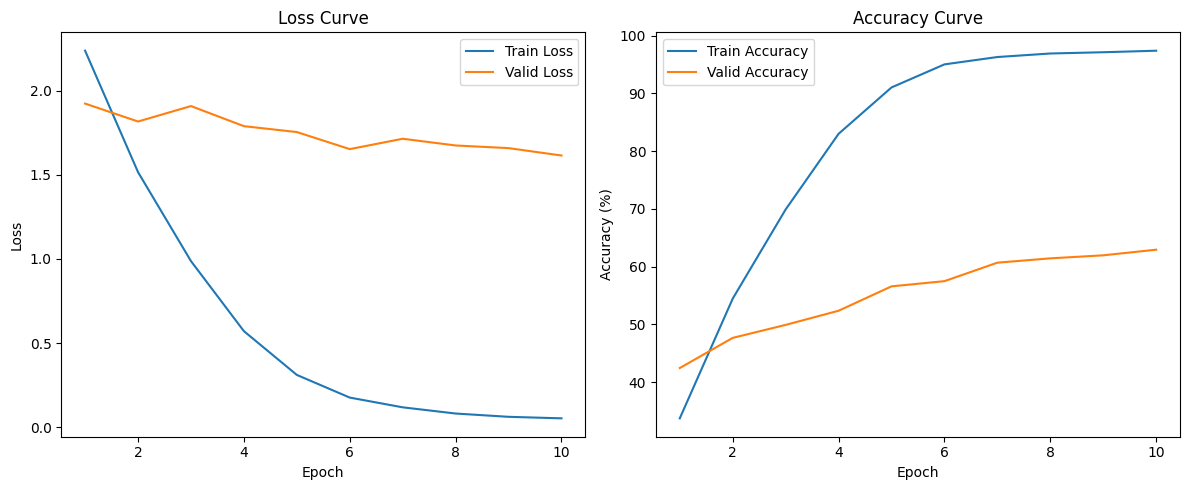

In [12]:
modelResNet = models.resnet50(pretrained=True)
modelResNet.fc = nn.Linear(modelResNet.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizerResNet = torch.optim.SGD(modelResNet.parameters(), lr = learning_rate, momentum = 0.8)

num_epochs = 10  # Set the number of epochs
trainModel(modelResNet,'ResNet', trainLoaderAlexNet,valLoaderAlexNet, criterion, optimizerResNet, device,num_epochs)
plotCurve('ResNet', train_losses['ResNet'],valid_losses['ResNet'],
          train_accuracies['ResNet'],valid_accuracies['ResNet'])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 136MB/s] 


Epoch 1/10
Train Loss: 2.3310, Train Accuracy: 31.84%
Valid Loss: 2.0483, Valid Accuracy: 40.80%
Epoch 2/10
Train Loss: 1.7948, Train Accuracy: 46.76%
Valid Loss: 1.8285, Valid Accuracy: 46.83%
Epoch 3/10
Train Loss: 1.4513, Train Accuracy: 56.59%
Valid Loss: 1.9258, Valid Accuracy: 45.95%
Epoch 4/10
Train Loss: 1.1474, Train Accuracy: 65.10%
Valid Loss: 1.7262, Valid Accuracy: 52.72%
Epoch 5/10
Train Loss: 0.8847, Train Accuracy: 72.64%
Valid Loss: 1.9582, Valid Accuracy: 51.30%
Epoch 6/10
Train Loss: 0.7392, Train Accuracy: 76.62%
Valid Loss: 1.8884, Valid Accuracy: 52.57%
Epoch 7/10
Train Loss: 0.5720, Train Accuracy: 81.92%
Valid Loss: 1.8509, Valid Accuracy: 55.37%
Epoch 8/10
Train Loss: 0.4910, Train Accuracy: 84.21%
Valid Loss: 2.0014, Valid Accuracy: 55.70%
Epoch 9/10
Train Loss: 0.3986, Train Accuracy: 87.18%
Valid Loss: 1.8817, Valid Accuracy: 58.10%
Epoch 10/10
Train Loss: 0.3276, Train Accuracy: 89.09%
Valid Loss: 1.9821, Valid Accuracy: 57.50%


/tmp/ipykernel_25/4036692992.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


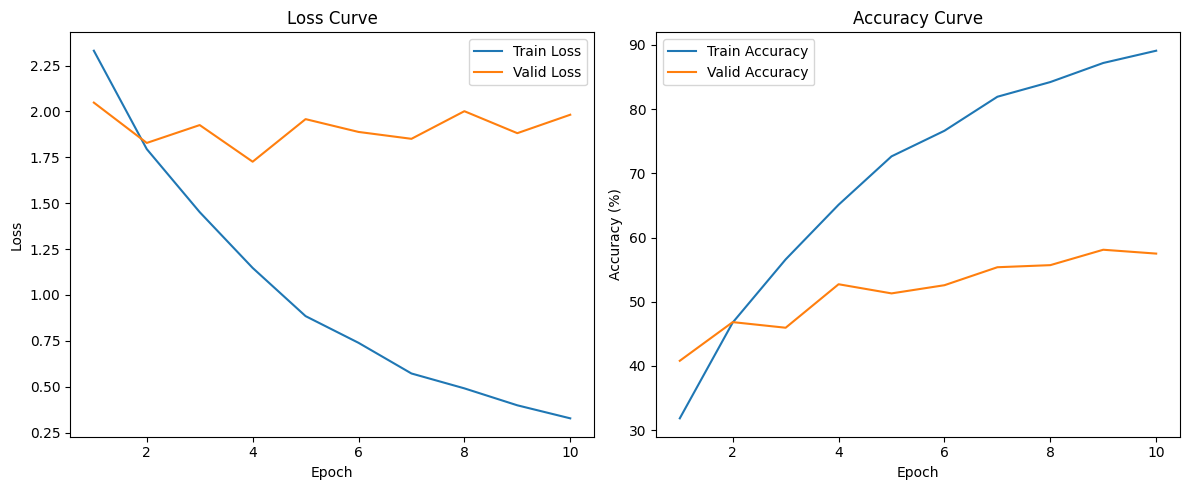

In [13]:
preprocessInception = transforms.Compose([
    transforms.Resize((299, 299)),
    #transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainDataInc = datasets.ImageFolder(root=train_dir, transform=preprocessInception)
trainLoaderInc = DataLoader(dataset= trainDataInc , batch_size= 32, shuffle=True,num_workers=4, pin_memory=True)
valDataDataInc = datasets.ImageFolder(root=test_dir, transform=preprocessInception)
valLoaderInc = DataLoader(dataset= valDataDataInc , batch_size= 32, shuffle=True,num_workers=4, pin_memory=True)

modelInception = models.inception_v3(pretrained=True)
modelInception.fc = nn.Linear(modelInception.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizerInc = torch.optim.SGD(modelInception.parameters(), lr = learning_rate, momentum = 0.8)

num_epochs = 10  # Set the number of epochs
trainModel(modelInception,'InceptionNet', trainLoaderInc,valLoaderInc, criterion, optimizerInc, device,num_epochs)
plotCurve('InceptionNet', train_losses['InceptionNet'],valid_losses['InceptionNet'],
          train_accuracies['InceptionNet'],valid_accuracies['InceptionNet'])

In [14]:
# # Example usage:
# # Assuming you have instances of your models
# models = {'CNN': modelCNN, 'AlexNet': modelAlexNet, 'ResNet': modelResNet, 'InceptionNet': modelInception}

# for model_name, model in models.items():
#     optimizer = optim.Adam(model.parameters(), lr=0.001)  # Example optimizer
#     criterion = nn.CrossEntropyLoss()  # Example loss function
#     trainModel(model, model_name, train_loader, val_loader, criterion, optimizer, device, num_epochs)